In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

In [2]:
from lib.Rdump import stan_rdump

In [3]:
import warnings
import yaml

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [6]:
cwd = os.getcwd()
cwd

'/data/DCM_ERP_Stan'

In [7]:
Res_dir='Res_CM_NMM_EPR_SensitivityAnalysis'

# ERP Simulator

In [8]:
tend = 200.0
dt=0.1
t0=0.0
ts = np.arange(t0, tend + dt, dt)

In [9]:
nt=ts.shape[0]
ns=9

In [10]:
x_init=np.zeros((ns))

In [11]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=12.13
tau_e=5.77
h_i=27.87
tau_i=7.77
h_e=1.63
u=3.94

In [12]:
theta_true_label=['$g_1$', '$g_2$', '$g_3$', '$g_4$', '$\delta$', '$tau_i$', '$h_i$', '$tau_e$','$h_e$', '$u$']

In [13]:
theta_true=np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
nn=theta_true.shape[0]
nn

10

In [14]:
alpha=-0.56

In [15]:
constants=np.array([alpha, ns])

In [16]:
from DCM_NMM_ERP_Simulator import DCM_NMM_ERP

In [17]:
DCM_NMM_ERP = numba.jit(DCM_NMM_ERP)

In [18]:
eps=0.0
sig=0.0

In [19]:
start_time = time.time()
_=DCM_NMM_ERP(theta_true, constants, x_init, sig, eps, dt, ts)
print(" single sim took (sec):" , (time.time() - start_time))

 single sim took (sec): 4.465340614318848


In [20]:
start_time = time.time()
xs_jit_ode_=DCM_NMM_ERP(theta_true, constants, x_init, sig, eps, dt, ts)
print(" single sim with JIT  took (sec):" , (time.time() - start_time))

 single sim with JIT  took (sec): 0.06655287742614746


In [21]:
xs_jit_ode=xs_jit_ode_.reshape(ns,nt)
xpy_jit_ode=xs_jit_ode[8,:]

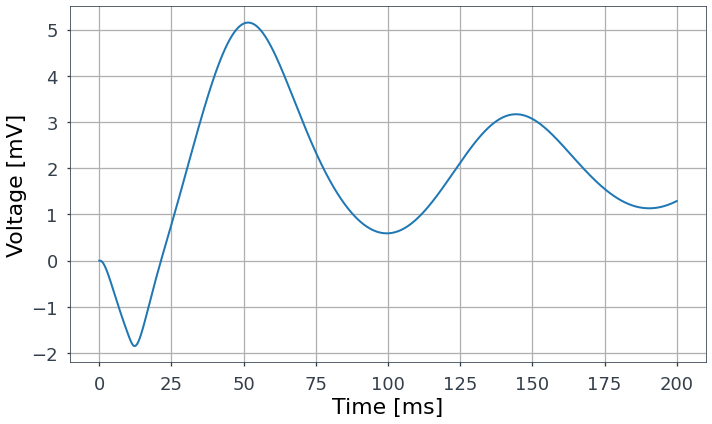

In [22]:
fig = plt.figure(figsize=(10,6))
plt.plot(ts, xpy_jit_ode, lw=2);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE.eps"), dpi=800)
plt.show()

### Sweep over parameters for Sensitivity Analysis

In [23]:
def Profile_likelihood(theta_true, param_range, param_idx, x_obs):

    theta_true=np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])

    params_val=theta_true
    
    Sweep_len=param_range.shape[0]
    RMSE=np.zeros((Sweep_len))
    
    ii=0
    for i in param_range:
        params_val[param_idx]=i
        xs_model=DCM_NMM_ERP(theta_true, constants, x_init, sig, eps, dt, ts)
        xpy_model=xs_model.reshape(ns,nt)[8,:]

        RMSE[ii]=np.sqrt(np.sum((xpy_model-x_obs)**2)/num_data)
        ii=ii+1
    return RMSE

In [24]:
# Δ_α denotes the α quantile of the χ2 distribution with df = 1 degrees of freedom for point-wise confidence intervals
#Critical Values of the Chi-Square Distribution with ν=1 degrees of freedom:

#Thresholds for confidence intervals corresponding to a confidence level of 95% 

#According to https://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm
# confidence level of 75% (a=0.25)=1.32
# confidence level of 80% (a=0.2)=1.642
# confidence level of 90%(a=0.1)= 2.706
# confidence level of 95%(a=0.05)= 3.841
# confidence level of 97.25%= 5.024
#
#The dashed lines display the threshold ∆_α utilised to asses likelihood-based confidence regions for a confidence level α. 


In [25]:
Delta=1.642

### OBS I

In [26]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=12.13
tau_e=5.77
h_i=27.87
tau_i=7.77
h_e=1.63
u=3.94

In [27]:
eps=0.1
sig=0.0

In [28]:
theta_true=np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
theta_true

array([ 0.42,  0.76,  0.15,  0.16, 12.13,  7.77, 27.87,  5.77,  1.63,
        3.94])

In [29]:
xs_jit_ode_=DCM_NMM_ERP(theta_true, constants, x_init, sig, eps, dt, ts)

xs_jit_ode=xs_jit_ode_.reshape(ns,nt)
xpy_jit_ode=xs_jit_ode[8,:]

In [30]:
x_obs=xpy_jit_ode
num_data=x_obs.shape[0]
num_data

2001

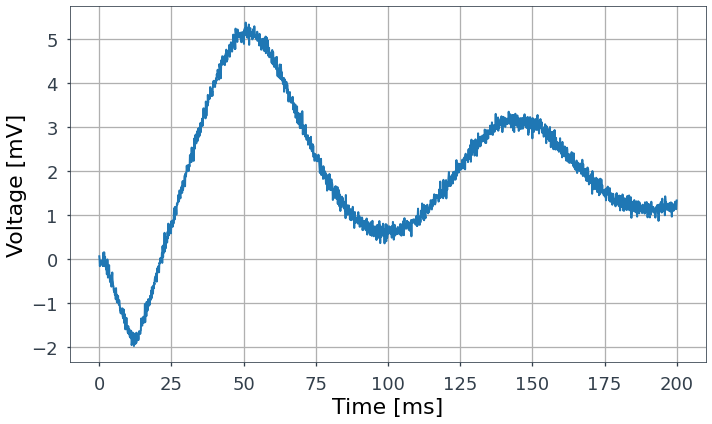

In [31]:
fig = plt.figure(figsize=(10,6))
plt.plot(ts, x_obs, lw=2);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE_Obs1.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE_Obs1.eps"), dpi=800)
plt.show()

In [32]:
param_range_g_1=np.arange(0,2,0.01)
param_range_g_2=np.arange(0,2,0.01)
param_range_g_3=np.arange(0,0.5,0.01)
param_range_g_4=np.arange(0,0.5,0.01)

param_range_delta=np.arange(0.,40,0.05)
param_range_tau_i=np.arange(0.01,20,0.05)
param_range_h_i=np.arange(0,50,0.05)
param_range_tau_e=np.arange(0.01,15,0.05)
param_range_h_e=np.arange(0,5,0.05)

param_range_u=np.arange(0,10,0.05)

In [33]:
Sen_g_1=Profile_likelihood(theta_true, param_range_g_1, 0, x_obs)
Sen_g_2=Profile_likelihood(theta_true, param_range_g_2, 1, x_obs)
Sen_g_3=Profile_likelihood(theta_true, param_range_g_3, 2, x_obs)
Sen_g_4=Profile_likelihood(theta_true, param_range_g_4, 3, x_obs)

Sen_delta=Profile_likelihood(theta_true, param_range_delta, 4, x_obs)
Sen_tau_i=Profile_likelihood(theta_true, param_range_tau_i, 5, x_obs)
Sen_h_i=Profile_likelihood(theta_true, param_range_h_i, 6, x_obs)
Sen_tau_e=Profile_likelihood(theta_true, param_range_tau_e, 7, x_obs)
Sen_h_e=Profile_likelihood(theta_true, param_range_h_e, 8, x_obs)

Sen_u=Profile_likelihood(theta_true, param_range_u, 9, x_obs)

In [34]:
param_range=np.array([param_range_g_1, param_range_g_2, param_range_g_3, param_range_g_4, param_range_delta, param_range_tau_i, param_range_h_i, param_range_tau_e, param_range_h_e, param_range_u ])
param_range.shape

(10,)

In [35]:
Sensitivity=np.array([Sen_g_1, Sen_g_2, Sen_g_3, Sen_g_4, Sen_delta, Sen_tau_i, Sen_h_i, Sen_tau_e, Sen_h_e, Sen_u ])
Sensitivity.shape

(10,)

In [36]:
np.save(os.path.join(Res_dir, 'param_range.npy') , param_range)
np.save(os.path.join(Res_dir, 'Sensitivity1.npy') , Sensitivity)

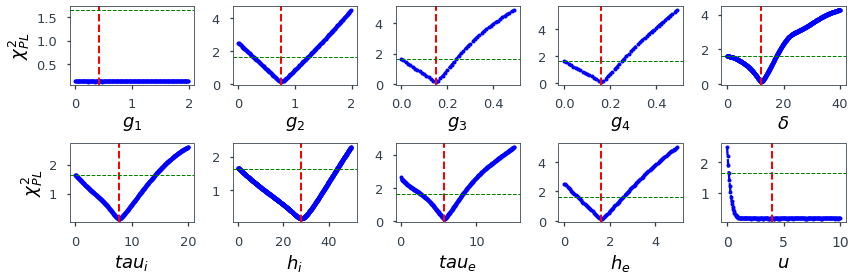

In [37]:
plt.figure(figsize=(12,4))
grid = plt.GridSpec(2, 5)  
i=0
for key in theta_true_label:
         plt.subplot(2,5,i+1)
         plt.plot(param_range[i], Sensitivity[i], '--o',  color='b', markersize=4);
         plt.axvline(x=theta_true[i], color='red', linestyle='--', lw=2)
         plt.axhline(y=Delta, color='g', linestyle='--', lw=1, label=r'$\Delta_\alpha$')

         if i==0 or i==5:
             plt.ylabel(r'$\chi^2_{PL}$',fontsize=18)  
         plt.xlabel((theta_true_label[i]), fontsize=18); 
         i=i+1
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)            
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs1.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs1.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs1.png"), dpi=800)
plt.show()            

### OBS II

In [38]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=2.13
tau_e=5.77
h_i=27.87
tau_i=7.77
h_e=1.63
u=3.94

In [39]:
theta_true=np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
theta_true

array([ 0.42,  0.76,  0.15,  0.16,  2.13,  7.77, 27.87,  5.77,  1.63,
        3.94])

In [40]:
xs_jit_ode_=DCM_NMM_ERP(theta_true, constants, x_init, sig, eps, dt, ts)

xs_jit_ode=xs_jit_ode_.reshape(ns,nt)
xpy_jit_ode=xs_jit_ode[8,:]

In [41]:
x_obs=xpy_jit_ode
num_data=x_obs.shape[0]
num_data

2001

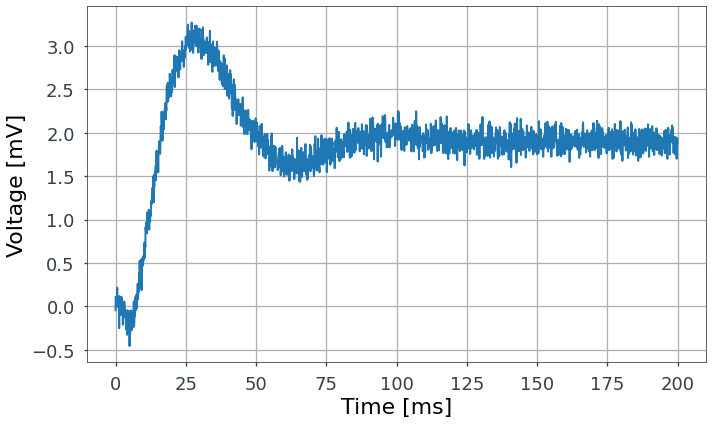

In [42]:
fig = plt.figure(figsize=(10,6))
plt.plot(ts, x_obs, lw=2);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE_Obs2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE_Obs2.eps"), dpi=800)
plt.show()

In [43]:
Sen_g_1=Profile_likelihood(theta_true, param_range_g_1, 0, x_obs)
Sen_g_2=Profile_likelihood(theta_true, param_range_g_2, 1, x_obs)
Sen_g_3=Profile_likelihood(theta_true, param_range_g_3, 2, x_obs)
Sen_g_4=Profile_likelihood(theta_true, param_range_g_4, 3, x_obs)

Sen_delta=Profile_likelihood(theta_true, param_range_delta, 4, x_obs)
Sen_tau_i=Profile_likelihood(theta_true, param_range_tau_i, 5, x_obs)
Sen_h_i=Profile_likelihood(theta_true, param_range_h_i, 6, x_obs)
Sen_tau_e=Profile_likelihood(theta_true, param_range_tau_e, 7, x_obs)
Sen_h_e=Profile_likelihood(theta_true, param_range_h_e, 8, x_obs)

Sen_u=Profile_likelihood(theta_true, param_range_u, 9, x_obs)

In [44]:
param_range=np.array([param_range_g_1, param_range_g_2, param_range_g_3, param_range_g_4, param_range_delta, param_range_tau_i, param_range_h_i, param_range_tau_e, param_range_h_e, param_range_u ])
param_range.shape

(10,)

In [45]:
Sensitivity=np.array([Sen_g_1, Sen_g_2, Sen_g_3, Sen_g_4, Sen_delta, Sen_tau_i, Sen_h_i, Sen_tau_e, Sen_h_e, Sen_u ])
Sensitivity.shape

(10,)

In [46]:
np.save(os.path.join(Res_dir, 'Sensitivity2.npy') , Sensitivity)

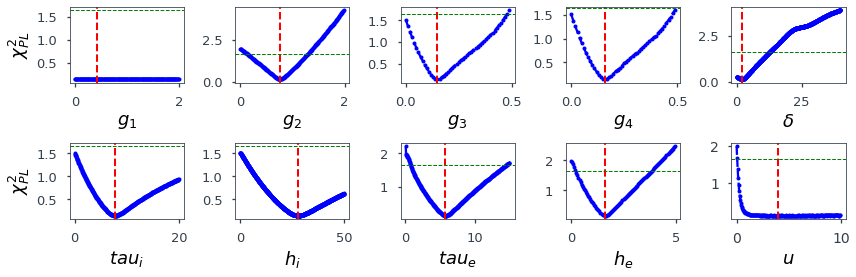

In [47]:
plt.figure(figsize=(12,4))
grid = plt.GridSpec(2, 5)  
i=0
for key in theta_true_label:
         plt.subplot(2,5,i+1)
         plt.plot(param_range[i], Sensitivity[i], '--o',  color='b', markersize=4);
         plt.axvline(x=theta_true[i], color='red', linestyle='--', lw=2)
         plt.axhline(y=Delta, color='g', linestyle='--', lw=1, label=r'$\Delta_\alpha$')

         if i==0 or i==5:
             plt.ylabel(r'$\chi^2_{PL}$',fontsize=18)  
         plt.xlabel((theta_true_label[i]), fontsize=18); 
         i=i+1
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)            
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs2.png"), dpi=800)
plt.show()            

### OBS III

In [48]:
g_1=0.42
g_2=0.76
g_3=0.15
g_4=0.16
delta=20.13
tau_e=5.77
h_i=27.87
tau_i=7.77
h_e=1.63
u=3.94

In [49]:
theta_true=np.array([g_1, g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u])
theta_true

array([ 0.42,  0.76,  0.15,  0.16, 20.13,  7.77, 27.87,  5.77,  1.63,
        3.94])

In [50]:
xs_jit_ode_=DCM_NMM_ERP(theta_true, constants, x_init, sig, eps, dt, ts)

xs_jit_ode=xs_jit_ode_.reshape(ns,nt)
xpy_jit_ode=xs_jit_ode[8,:]

In [51]:
x_obs=xpy_jit_ode
num_data=x_obs.shape[0]
num_data

2001

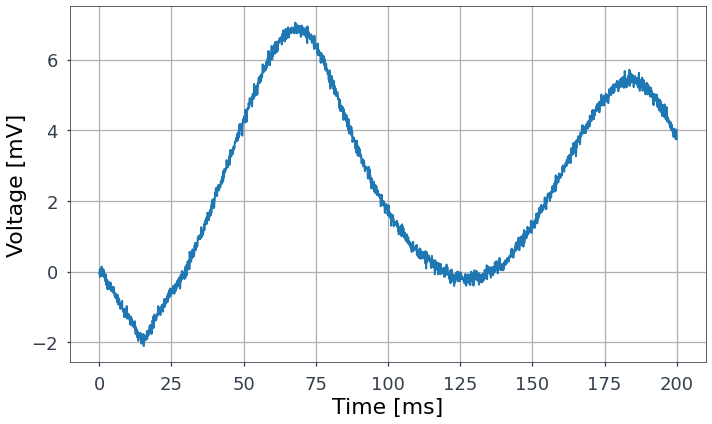

In [52]:
fig = plt.figure(figsize=(10,6))
plt.plot(ts, x_obs, lw=2);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE_Obs2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"DCM_EPR_EulerJit_ODE_Obs2.eps"), dpi=800)
plt.show()

In [53]:
Sen_g_1=Profile_likelihood(theta_true, param_range_g_1, 0, x_obs)
Sen_g_2=Profile_likelihood(theta_true, param_range_g_2, 1, x_obs)
Sen_g_3=Profile_likelihood(theta_true, param_range_g_3, 2, x_obs)
Sen_g_4=Profile_likelihood(theta_true, param_range_g_4, 3, x_obs)

Sen_delta=Profile_likelihood(theta_true, param_range_delta, 4, x_obs)
Sen_tau_i=Profile_likelihood(theta_true, param_range_tau_i, 5, x_obs)
Sen_h_i=Profile_likelihood(theta_true, param_range_h_i, 6, x_obs)
Sen_tau_e=Profile_likelihood(theta_true, param_range_tau_e, 7, x_obs)
Sen_h_e=Profile_likelihood(theta_true, param_range_h_e, 8, x_obs)

Sen_u=Profile_likelihood(theta_true, param_range_u, 9, x_obs)

In [54]:
param_range=np.array([param_range_g_1, param_range_g_2, param_range_g_3, param_range_g_4, param_range_delta, param_range_tau_i, param_range_h_i, param_range_tau_e, param_range_h_e, param_range_u ])
param_range.shape

(10,)

In [55]:
Sensitivity=np.array([Sen_g_1, Sen_g_2, Sen_g_3, Sen_g_4, Sen_delta, Sen_tau_i, Sen_h_i, Sen_tau_e, Sen_h_e, Sen_u ])
Sensitivity.shape

(10,)

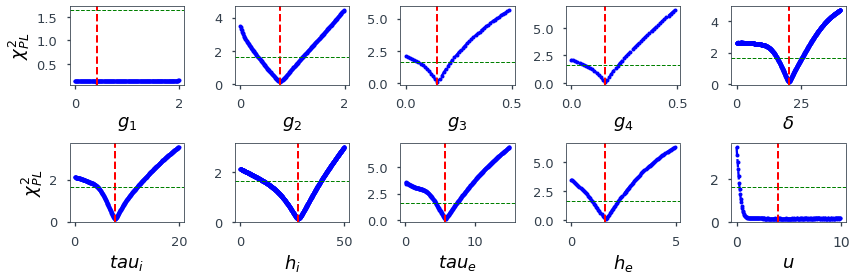

In [56]:
plt.figure(figsize=(12,4))
grid = plt.GridSpec(2, 5)  
i=0
for key in theta_true_label:
         plt.subplot(2,5,i+1)
         plt.plot(param_range[i], Sensitivity[i], '--o',  color='b', markersize=4);
         plt.axvline(x=theta_true[i], color='red', linestyle='--', lw=2)
         plt.axhline(y=Delta, color='g', linestyle='--', lw=1, label=r'$\Delta_\alpha$')
         if i==0 or i==5:
             plt.ylabel(r'$\chi^2_{PL}$',fontsize=18)  
         plt.xlabel((theta_true_label[i]), fontsize=18); 
         i=i+1
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)            
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SensitivityAnlysis_EPR_obs2.png"), dpi=800)
plt.show()            

In [57]:
np.save(os.path.join(Res_dir, 'Sensitivity3.npy') , Sensitivity)

### Random Vizualization

In [58]:
Sim_dir='Res_CM_NMM_EPR_SensitivityAnalysis'

In [59]:
import torch
import sbi 

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi ,simulate_for_sbi

import sbi.utils as utils
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [60]:
@jit(nopython=False)
def DCM_NMM_ERP_simulator_wrapper(params):
    
    params = np.asarray(params)
    
    tend = 200.0
    dt=0.1
    t0=0.0
    ts = np.arange(t0, tend + dt, dt)

    alpha=-0.56
    nn=int(9)
    nt=ts.shape[0]
    
    constants=np.array([alpha, nn])
    
    x_init=np.zeros((nn))
    
    eps=0.0
    sig=0.0
    
    Sim_ = DCM_NMM_ERP(params, constants, x_init, sig, eps, dt, ts)

    Simulated_ERP=Sim_.reshape(nn,nt)
    Simulated_ERP_Pyramid=Simulated_ERP[8,:]
     
    return Simulated_ERP_Pyramid.reshape(-1)

In [61]:
# g_1=0.42
# g_2=0.76
# g_3=0.15
# g_4=0.16
# delta=12.13
# tau_e=5.77
# h_i=27.87
# tau_i=7.77
# h_e=1.63
# u=3.94

In [62]:
try:
    os.mkdir(Sim_dir+'/output_simulations')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [63]:
num_sim=100

In [64]:
mysavepath = os.path.join(cwd+'/'+Sim_dir , 'output_simulations/simulated_theta_x_dcm_nmm_erp_ode_eps00_t200msec_'+str(num_sim)+'sims.npz')
mysavepath

'/data/DCM_ERP_Stan/Res_CM_NMM_EPR_SensitivityAnalysis/output_simulations/simulated_theta_x_dcm_nmm_erp_ode_eps00_t200msec_100sims.npz'

In [65]:
def Save_simulations(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(simulator=simulator,
                                proposal=prior,
                                num_simulations=num_simulations,
                                show_progress_bar=True,)

    print( 'theta shape:',theta.shape,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)

In [66]:
# delay

In [67]:
prior_min = [g_1, g_2, g_3, g_4, 1, tau_i, h_i, tau_e, h_e, u]
prior_max = [g_1, g_2, g_3, g_4, 50, tau_i, h_i, tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [68]:
len(prior_min), len(prior_max)

(10, 10)

In [69]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [70]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [71]:
loaded_simulations=np.load(mysavepath)

In [72]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [73]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


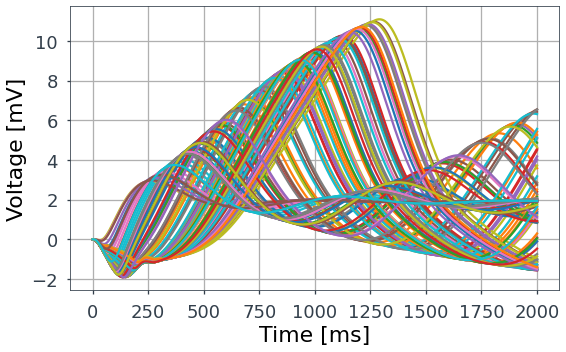

In [74]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"RandomDelay.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"RandomDelay.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"RandomDelay.png"), dpi=800)

In [75]:
# g1

In [76]:
prior_min = [0., g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]
prior_max = [2., g_2, g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [77]:
len(prior_min), len(prior_max)

(10, 10)

In [78]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [79]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [80]:
loaded_simulations=np.load(mysavepath)

In [81]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [82]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


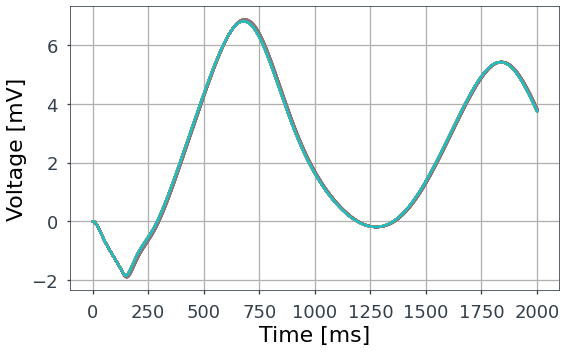

In [83]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg1.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg1.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg1.png"), dpi=800)

In [84]:
# g2

In [85]:
prior_min = [g_1, 0., g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]
prior_max = [g_1, 2., g_3, g_4, delta, tau_i, h_i, tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [86]:
len(prior_min), len(prior_max)

(10, 10)

In [87]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [88]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [89]:
loaded_simulations=np.load(mysavepath)

In [90]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [91]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


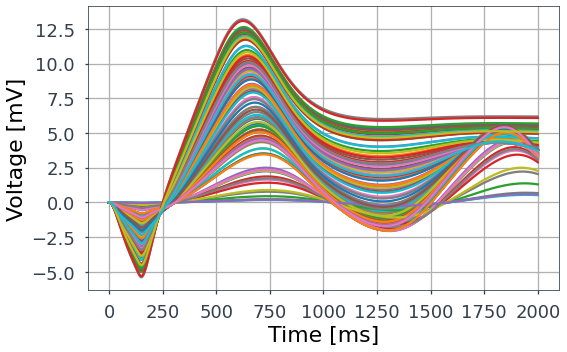

In [92]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg2.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg2.png"), dpi=800)

In [93]:
# g3

In [94]:
prior_min = [g_1, g_2, 0, g_4, delta, tau_i, h_i, tau_e, h_e, u]
prior_max = [g_1, g_2, 1, g_4, delta, tau_i, h_i, tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [95]:
len(prior_min), len(prior_max)

(10, 10)

In [96]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [97]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [98]:
loaded_simulations=np.load(mysavepath)

In [99]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [100]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


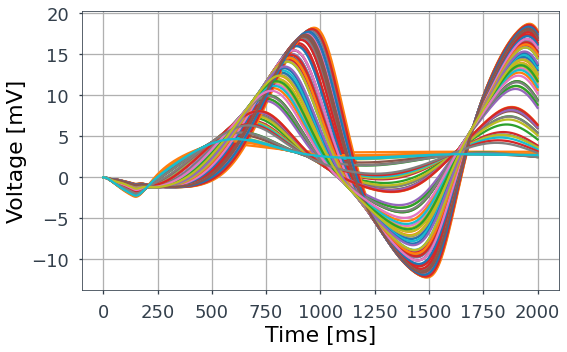

In [101]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg3.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg3.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg3.png"), dpi=800)

In [102]:
# g4

In [103]:
prior_min = [g_1, g_2, g_3, 0,  delta, tau_i, h_i, tau_e, h_e, u]
prior_max = [g_1, g_2, g_3, 1., delta, tau_i, h_i, tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [104]:
len(prior_min), len(prior_max)

(10, 10)

In [105]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [106]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [107]:
loaded_simulations=np.load(mysavepath)

In [108]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [109]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


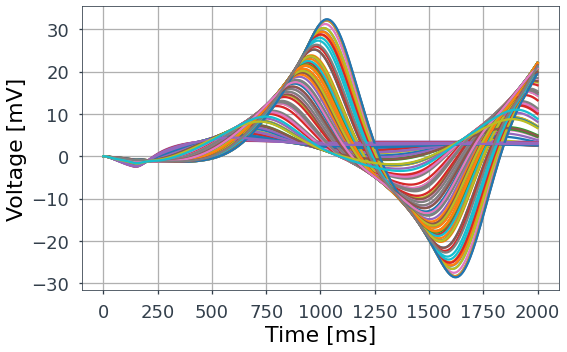

In [110]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg4.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg4.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomg4.png"), dpi=800)

In [111]:
# tau_i

In [112]:
prior_min = [g_1, g_2, g_3, g_4, delta, 0.1, h_i, tau_e, h_e, u]
prior_max = [g_1, g_2, g_3, g_4, delta, 20., h_i, tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [113]:
len(prior_min), len(prior_max)

(10, 10)

In [114]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [115]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [116]:
loaded_simulations=np.load(mysavepath)

In [117]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [118]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


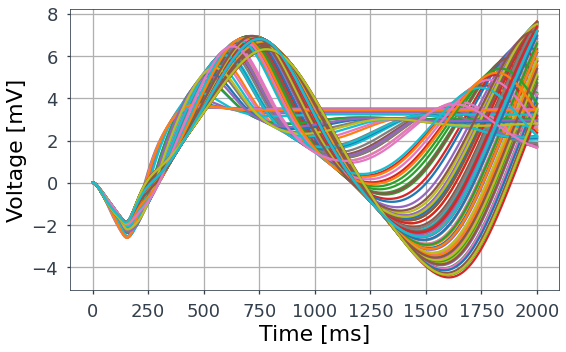

In [119]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomtaui.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomtaui.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomtaui.png"), dpi=800)

In [120]:
# hi

In [121]:
prior_min = [g_1, g_2, g_3, g_4, delta, tau_i, 0.1, tau_e, h_e, u]
prior_max = [g_1, g_2, g_3, g_4, delta, tau_i, 50., tau_e, h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [122]:
len(prior_min), len(prior_max)

(10, 10)

In [123]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [124]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [125]:
loaded_simulations=np.load(mysavepath)

In [126]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [127]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


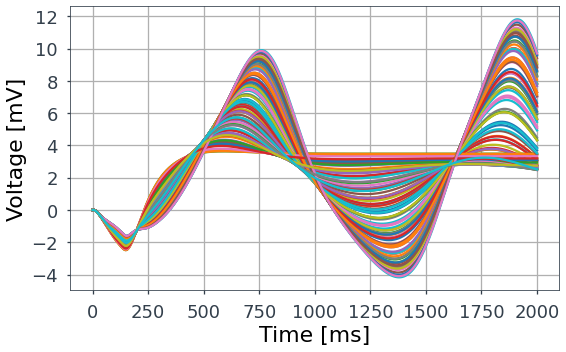

In [128]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomhi.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomhi.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomhi.png"), dpi=800)

In [129]:
# tau_e

In [130]:
prior_min = [g_1, g_2, g_3, g_4, delta, tau_i, h_i, 0.1, h_e, u]
prior_max = [g_1, g_2, g_3, g_4, delta, tau_i, h_i, 15., h_e, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [131]:
len(prior_min), len(prior_max)

(10, 10)

In [132]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [133]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [134]:
loaded_simulations=np.load(mysavepath)

In [135]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [136]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


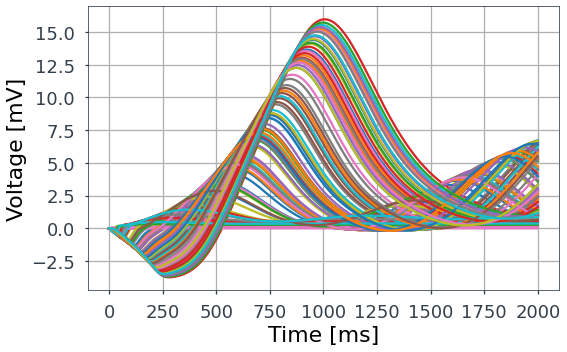

In [137]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomtaue.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomtaue.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomtaue.png"), dpi=800)

In [138]:
# h_e

In [139]:
prior_min = [g_1, g_2, g_3, g_4, delta, tau_e, h_e, tau_i, 0.1, u]
prior_max = [g_1, g_2, g_3, g_4, delta, tau_e, h_e, tau_i, 5, u]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [140]:
len(prior_min), len(prior_max)

(10, 10)

In [141]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [142]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [143]:
loaded_simulations=np.load(mysavepath)

In [144]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [145]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


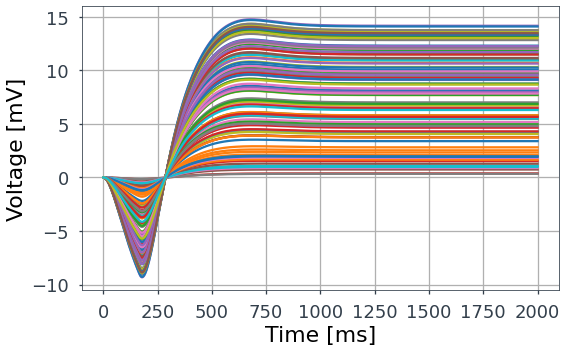

In [146]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomhe.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomhe.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomhe.png"), dpi=800)

In [147]:
#u
theta_true_label=['$g_1$', '$g_2$', '$g_3$', '$g_4$', '$\delta$', '$tau_i$', '$h_i$', '$tau_e$','$h_e$', '$u$']

In [148]:
prior_min = [g_1, g_2, g_3, g_4, delta, tau_e, h_e, tau_i, h_i, 0.]
prior_max = [g_1, g_2, g_3, g_4, delta, tau_e, h_e, tau_i, h_i, 10]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [149]:
len(prior_min), len(prior_max)

(10, 10)

In [150]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 10


In [151]:
Save_simulations(DCM_NMM_ERP_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

A Jupyter Widget


theta shape: torch.Size([100, 10])
data shape: torch.Size([100, 2001])


In [152]:
loaded_simulations=np.load(mysavepath)

In [153]:
theta_sim=loaded_simulations['theta']
x_sim=loaded_simulations['x']

In [154]:
print( 'theta shape:',theta_sim.shape,flush=True)
print('data shape:', x_sim.shape,flush=True)

theta shape: (100, 10)
data shape: (100, 2001)


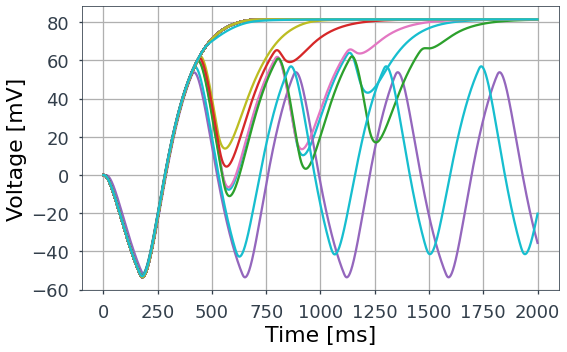

In [155]:
plt.figure(figsize=(8,5))
plt.plot(x_sim.T);
plt.ylabel('Voltage [mV]', fontsize=22); 
plt.xlabel('Time [ms]', fontsize=22); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomu.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomu.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Randomu.png"), dpi=800)